# I. Introduction 

### Définition du problème et exploration des données

L'objectif du projet est de développer un modèle de classification de
produits e-commerce Rakuten, capable de prédire un code type de
produit à partir de données multimodales :
- textes(désignation et description des produits),
- images associées.

Cette classification est utile pour :
- exploiter efficacement le contenu fourni par les vendeurs,
- éviter les doublons,
- faciliter la gestion du catalogue,
- améliorer la recommandation et la personnalisation du parcours
utilisateur.

Le projet s'inscrit dans le cadre du challenge :
**https://challengedata.ens.fr/challenges/35**

Ce challenge présente plusieurs difficultés :
- données bruitées (textes et images),
- grand nombre de produits,
- distribution déséquilibrée des classes


### Description du jeu de données

Les données sont composées de :

### **Fichiers CSV**

-   **X_train.csv** : données d'entraînement (84 916 produits)
-   **Y_train.csv** : labels associés
-   **X_test.csv** : données de test (13 812 produits)

### **Images**

Un dossier compressé qui contient : 
- **image_training**
- **image_test**

### Structure du dataset

-   Données multimodales : texte + image
-   Données bruitées
-   Classes nombreuses (27)
-   Taille importante (près de 85 000 produits)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import cv2
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabyd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# importation des données du jeu d'entraînement

data_path = "../data/raw/"
df = pd.read_csv(data_path+"X_train_update.csv").drop("Unnamed: 0", axis=1)
y = pd.read_csv(data_path+"Y_train_CVw08PX.csv")['prdtypecode']
df = pd.concat([y, df], axis=1)

print(df.info())
display(df.head())
print(f"La variable cible a {df["prdtypecode"].nunique()} modalités différentes.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   prdtypecode  84916 non-null  int64 
 1   designation  84916 non-null  object
 2   description  55116 non-null  object
 3   productid    84916 non-null  int64 
 4   imageid      84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.2+ MB
None


prdtypecode                                        designation  \
0           10  Olivia: Personalisiertes Notizbuch / 150 Seite...   
1         2280  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
2           50  Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
3         1280  Peluche Donald - Europe - Disneyland 2000 (Mar...   
4         2705                               La Guerre Des Tuques   

                                         description   productid     imageid  
0                                                NaN  3804725264  1263597046  
1                                                NaN   436067568  1008141237  
2  PILOT STYLE Touch Pen de marque Speedlink est ...   201115110   938777978  
3                                                NaN    50418756   457047496  
4  Luc a des id&eacute;es de grandeur. Il veut or...   278535884  1077757786

La variable cible a 27 modalités différentes.


Il n'y a pas toujours de descriptions mais les designations ne sont jamais NaN, ni les productid et les imageid qui vont nous servir à récupérer les images car les noms des fichiers images sont de la forme image_*imageid*\_product_*productid*.jpg <br>
Nous allons vérifier que chaque porductid et imageid est unique et récupérer les chemins des images dans la variable "image".

In [3]:
print(f"Il y a {df['productid'].duplicated(keep=False).sum()} duplicata pour productid")
print(f"Il y a {df['imageid'].duplicated(keep=False).sum()} duplicata pour imageid")

# on enregistre le chemin de l'image correspondant à chaque article dans une colonne image
df['image'] = data_path +"images/image_train/image_" + df['imageid'].astype('str') + '_product_' + df['productid'].astype('str') +'.jpg'

Il y a 0 duplicata pour productid
Il y a 0 duplicata pour imageid


Les productid sont tous uniques on peut donc réindexer df par cette colonne. Les imageid ne sont plus nécessaire maintenant qu'on a récupérer le chemin on va donc supprimer la colonne imageid.

In [4]:
df = df.set_index("productid").drop('imageid', axis=1)

# 2 - Nettoyage du texte



En regardant les designations et les descriptions on peut remarquer que certains textes comportent des balises html, des entités html et des caractères qui semblent mals encodés. Nous allons donc écrire une fonction qui permet de nettoyer le texte à l'aide des librairie regex, html (pour traîter les entités html) et ftfy et unicodedata (pour la gestion de l'encodage).

In [5]:
import regex as reg
import html, ftfy, unicodedata

# Fonction pour nettoyer et standardiser les données textuelles:
def nettoyer_texte(text):
    if pd.isna(text): return ""
    s = str(text)
    s = reg.sub(r"<[^>]+>", " ", s)          # Supprime HTML
    s = html.unescape(s)                     # Décode entités HTML
    s = ftfy.fix_text(s)                     # Corrige texte cassé
    s = unicodedata.normalize("NFC", s)      # Normalise Unicode
    s = reg.sub(r"(?<!\d)\.(?!\d)", " ", s)  # Supprime points non numériques
    s = s.replace("/", " ")
    s = s.replace("*", " ")
    s = s.replace(":", " ")
    # s = s.replace("-", " ")
    s = s.replace("////", " ")    
    s = reg.sub(r"\s+", " ", s).strip()     # Nettoie espaces et casse
    return s

# Le texte de ce produit rencontre les problèmes décrits nous allons donc tester la fonction de nettoyage dessus
productid = 4108914287                      
description = df.iloc[14]['description']

print(f"--- productid {productid} [texte original] ---")
print(description)
print("\n" + "="*40 + "\n")
print(f"--- productid {productid} [texte nettoyé] ---")
print(nettoyer_texte(description))

--- productid 4108914287 [texte original] ---
MATELAS:<br />Â· Accueil : Ferme .<br />Â· Soutien : Très Ferme .<br />Â· Technologie matelas : Face été &#43; à¢me en Mousse Poli Lattex Dernière Génération Indéformable Très Haute Résilience - Face Hiver 45 cm de Mousse à  Mémoire de Forme Très Haute Densité 60 Kg/m3 &#34; Massante&#34;<br />Â· Épaisseur du matelas : &#43;/- 20 cm.<br />Â· REPOS PLUS SAIN grà¢ce au Traitement Anti-acariens / anti-bactérien / Anti-moisissures.<br />Â· Très Bonne Indépendance de couchage.<br />Â· DORMEZ TRANQUILLE avec la Garantie 5 ans.  Il est Compatible avec les Sommiers Mécaniques et électriques<br />Coutil:<br />Â· Coutil stretch matelassé de 290 gr/m2 de Polyester avec traitement Sanitized. Faces de couchage Réversibles - Déhoussable sur 3 Cà¿tés et Housse Lavable à  30Â° position Lavage à  la main Délicat -<br />Â· SANITIZED : Traitement antibactérien et anti-moisissures diminuant également le développement des odeurs.<br />Structure et garnissage du

#### voir pour integrer graphique de distribution des mots fréquents avant et après nettoyage

Nous pouvons vérifier si cette fonction permet de detecter des doublons textuelles supplémentaire

In [6]:
df["cleaned_designation"] = df["designation"].apply(nettoyer_texte)
df["cleaned_description"] = df["description"].apply(nettoyer_texte)

print(f"Avant nettoyage il y a {df[["designation", "description", "prdtypecode"]].duplicated(keep=False).sum()} duplicata textuels.")
print(f"Après nettoyage il y a {df[["cleaned_designation", "cleaned_description", "prdtypecode"]].duplicated(keep=False).sum()} duplicata textuels.")

Avant nettoyage il y a 2311 duplicata textuels.
Après nettoyage il y a 2358 duplicata textuels.


# 3 - Doublons (texte + image)

Pour identifier les lignes qui sont de véritables doublons, il faudrait vérifier qu'en plus d'un texte identique, elles aient des images identiques. Pour comparer les images nous allons utiliser la méthode de hashage hash pour attribuer un identifiant à chaque photos. Cette identifiant sera différents quand deux photos seront différentes sinon il sera identique.

In [7]:
# génère le hashage en fonction d'une liste de chemin

def generate_hash(paths):
    hashed_contents = []
    for path in paths:
        with open(path, 'rb') as f:
            hashed_contents.append(hash(f.read()))  # on récupère le contenu du fichier puis on le hash
    return hashed_contents

df['hashed_image'] = generate_hash(df['image'])

Nous pouvons maintenant vérifier combien notre jeu de données a de doublons et les supprimer

In [8]:
n_duplicates = df[['cleaned_designation', 'cleaned_description', 'hashed_image', 'prdtypecode']].duplicated(keep=False).sum()
print(f"Il y a {n_duplicates} duplicata. Ce qui correspond à {round((n_duplicates/len(df))*100, 1)} % des produits.")

df = df.drop_duplicates(subset=['cleaned_designation', 'cleaned_description', 'hashed_image', 'prdtypecode'])

Il y a 634 duplicata. Ce qui correspond à 0.7 % des produits.


In [9]:
n_duplicata_wdiff_prdtypecode = df[['cleaned_designation', 'cleaned_description', 'hashed_image']].duplicated(keep=False).sum()
print(f"Il y a {n_duplicata_wdiff_prdtypecode} lignes qui ont un doublon sur le texte et l'image mais avec un prdtypecode différent.")

Il y a 16 lignes qui ont un doublon sur le texte et l'image mais avec un prdtypecode différent.


Certains produits identiques sont classés dans plusieurs catégories. Il faudra analyser si des catégories se "chevauchent" ou si ce sont plutôt des produits rangé dans la mauvaise catégorie. Pour commencer nous allons identifier les différentes catégories.

# 4 - Identification des catégories

Dans le but d'identifier les catégories correspondant à chaque code produit, il serait interessant d'afficher les images et les descriptions complètent ensemble. On va utiliser la fonction *display_df* qui permet d'afficher les images dans les cellules du dataframe à partir de leur chemin.

Nous allons procéder en filtrant sur une catégorie spécifique (ici cat = 10) et en affichant les premières entrées associées avec display_df, nous examinons les produits qui la composent.
L’observation se fait à la fois sur les images, mais également sur le contenu textuel des colonnes "designation" et "description".
Cette analyse nous permet de proposer un nom pertinent et cohérent pour la catégorie, nom qui sera ensuite contrasté et affiné à l’aide des nuages de mots générés afin de valider ou ajuster la dénomination retenue.

In [10]:
# fonction qui permet d'afficher les images du dataframe à partir du chemin des images
# et également les descriptions complètes

from IPython.display import HTML

def display_df(df, max_length=5):
    formatters={
        "image": lambda path: f'<img src="{path}" width="200">',
    }
    display(HTML(df.head(max_length).to_html(escape=False, formatters=formatters)))

# on affiche les premières lignes de la catégorie de code 10 avec l'image correspondante
display_df(df[df['prdtypecode']==10][['cleaned_designation', 'cleaned_description', 'image']], 3)

Ici la catégorie 10 semble représenter des livres. En regardant chaque catégorie nous arrivons à les identifier. Nous allons maintenant donner un nom aux catégories identifiées dans la colonne *categories*.<br>
*L'identification des catégories s'est également appuyée sur des graphiques comme les nuages de mots qui seront vu plus loin dans ce notebook mais pour rendre les graphiques qui suivent plus compréhensible nous avont décider de les renommer maintenant.*

In [11]:
categories = {
    "Livres & Revues": {
        "Livres spécialisés": 10,
        "Littérature": 2705,
        "Presse & Magazines": 2280,
        "Séries & Encyclopédies": 2403,
    },

    "Jeux Vidéo": {
        "Rétro Gaming": 40,
        "Accessoires & Périphériques": 50,
        "Consoles": 60,
        "Jeux Vidéo Modernes": 2462,
        "Jeux PC en Téléchargement": 2905,
    },

    "Collection": {
        "Figurines": 1140,
        "Jeux de cartes": 1160,
        "Jeux de rôle & Figurines": 1180,
    },

    "Jouets, Jeux & Loisirs": {
        "Jouets & Figurines": 1280,
        "Jeux éducatifs": 1281,
        "Modélisme & Drones": 1300,
        "Loisirs & Plein air": 1302,
    },

    "Bébé": {
        "Vêtement Bébé & Loisirs": 1301,
        "Puériculture": 1320,
    },

    "Maison": {
        "Équipement Maison": 1560,
        "Textiles d'intérieur": 1920,
        "Décoration & Lumières": 2060,
    },

    "Jardin & Extérieur": {
        "Décoration & Équipement Jardin": 2582,
        "Piscine & Accessoires": 2583,
        "Bricolage & Outillage": 2585,
    },

    "Autres": {
        "Épicerie": 1940,
        "Animaux": 2220,
        "Bureau & Papeterie": 2522,
    }
}

groups_mapper = {}
categories_mapper = {}
for group, g_categories in categories.items():
    for cat, code in g_categories.items():
        groups_mapper[code] = group
        categories_mapper[code] = cat

df['category'] = df['prdtypecode'].replace(categories_mapper)
df['group'] = df['prdtypecode'].replace(groups_mapper)

# 5 - Distribution des produits par catégorie

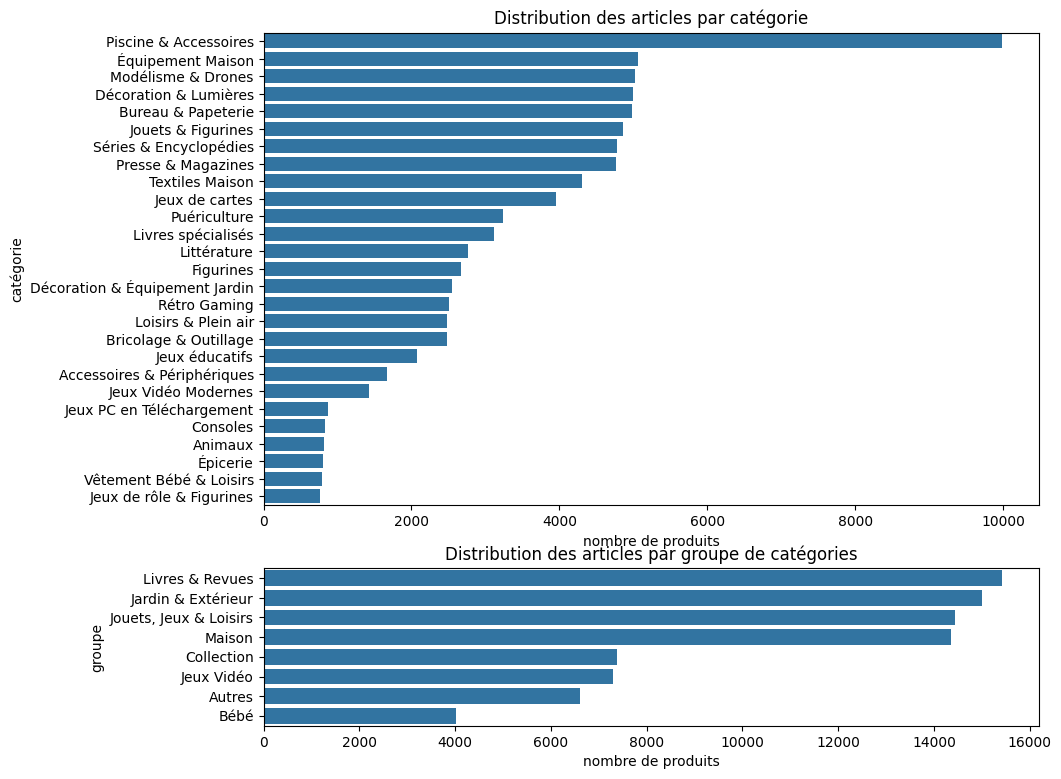

La catégorie la plus représentée est Piscine & Accessoires.
Elle à  13.1  fois plus d'articles que la catégorie Jeux de rôle & Figurines qui est la moins représentée.




In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,9), gridspec_kw={"height_ratios": [3, 1]})

cat_counts = df['category'].value_counts()
sns.barplot(x=cat_counts.values, y=cat_counts.index, ax=ax1)
ax1.set_ylabel('catégorie')
ax1.set_xlabel('nombre de produits')
ax1.set_title('Distribution des articles par catégorie')

group_counts = df['group'].value_counts()
sns.barplot(x=group_counts.values, y=group_counts.index, ax=ax2)
ax2.set_ylabel('groupe')
ax2.set_xlabel('nombre de produits')
ax2.set_title('Distribution des articles par groupe de catégories')

plt.show()

print(
    f"La catégorie la plus représentée est {cat_counts.index[0]}.\nElle à ",
    round(cat_counts.iloc[0]/cat_counts.iloc[-1],1),
    f" fois plus d'articles que la catégorie {cat_counts.index[-1]} qui est la moins représentée.\n\n"
)

Nous remarquons que le jeu de données est déséquilibré. Il sera donc important de stratifier notre jeu lors des splits entrainement / validation pour conserver la distribution dans chaucun de ces jeux et éviter d'avoir une classe ignoré car trop peux présente cela pourrait rendre les modèles pas performants sur certaines classes ou faussé l'évaulation car certaines classe y serait sous ou sur représentées. Nous avions vu que environ 30 000 description etait manquante. Nous allons maintenant regarder si certaines catégories on plus de description manquante que d'autre.

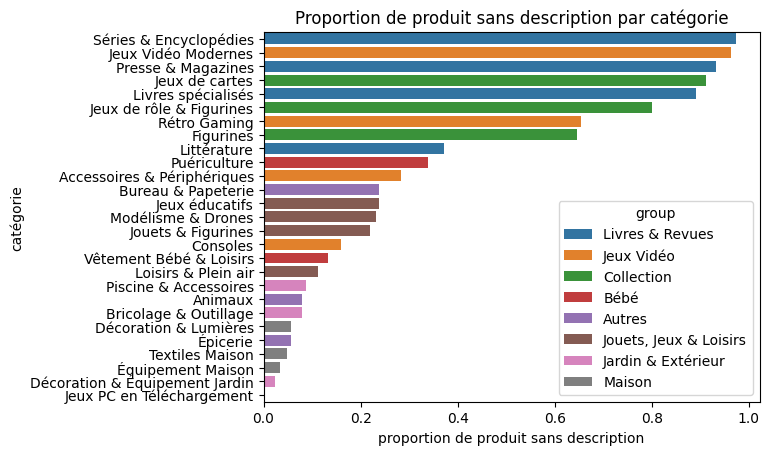

In [17]:
na_rates = df[df['description'].isna()][['group', 'category']].value_counts() / df[['group', 'category']].value_counts()
na_rates = na_rates.fillna(0).sort_values(ascending=False).reset_index()
sns.barplot(data=na_rates, x='count', y='category', hue='group')
plt.xlabel("proportion de produit sans description")
plt.ylabel("catégorie")
plt.title('Proportion de produit sans description par catégorie');

Ici on remarque que des catégories de produit comme les livres, les revues n'ont pas beaucoup de description, alors que les équipements de la maison ont en souvent. Cela semble cohérent en général seul le titre d'un livre est nécessaire alors que pour les équipements il est souvent utile de décrire les dimensions par exemple.

[expliquer pourquoi les jeux de PC n'ont aucune description]

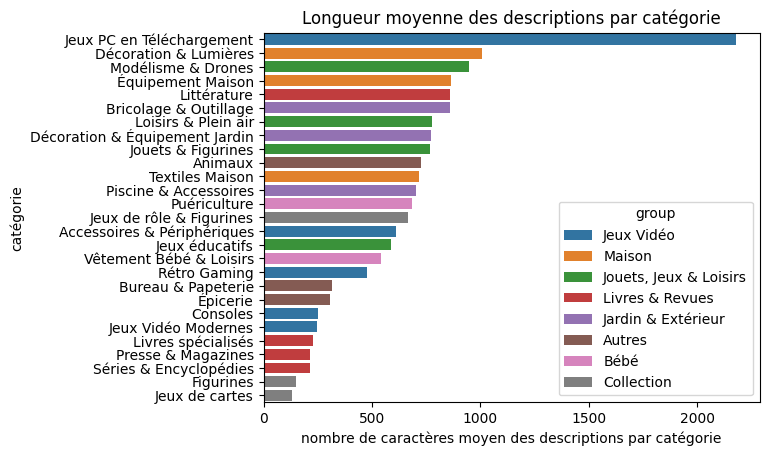

In [18]:
df["cleaned_description_len"] = df["cleaned_description"].apply(len)
len_means = df[~df['description'].isna()].groupby(['group', 'category'])["cleaned_description_len"].mean()
len_means = len_means.sort_values(ascending=False).reset_index()
sns.barplot(data=len_means, x='cleaned_description_len', y='category', hue='group')
plt.xlabel("nombre de caractères moyen des descriptions par catégorie")
plt.ylabel("catégorie")
plt.title('Longueur moyenne des descriptions par catégorie');

En plus d'avoir toujours des descriptions les jeux de PC en téléchargement semblent être très longue avec plus de 2000 caractères en moyenne.

# 6 - Traitement des mauvaises classifications

Le jeu de données est brut et il y a beaucoup de produits classé dans la mauvaise catégorie. Nous allons donc etiqueté les produits qui semblent mal classifiés. Pour cela nous allons utiliser la vectorisation TF-IDF précedemment faite, puis utilisé un modèle de régression logistique entrainé sur les variables issues de la vectorisation et à l'aide de la librairie CleanLearning detecter les produits "suspects". Les données pour lesquels le modèle va prédire une autre classe avec une probabilité élevée seront etiqueté comme suspectes.

In [20]:
stop_words = set(stopwords.words('french'))   # on récupère un stopwords adapté au français

# le paramètre ngram_range=(1,2) permet de récupérer unigramme et bigramme
# (par default c'est uniquement les unigrammes, i.e. séquence de un seul mot)
vectorizer = TfidfVectorizer(max_features=2000, stop_words=list(stop_words), ngram_range=(1,2))

text = (df["cleaned_designation"] + " " + df["cleaned_description"].fillna("")).str.lower()
tfidf = vectorizer.fit_transform(text)
tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)
tfidf["category"] = df["category"].values

In [29]:
from cleanlab.classification import CleanLearning
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

enc = LabelEncoder()                              # il faut encoder sinon ça provoque une erreur; pour k classes les labels doivent être 0,...,k-1
y = enc.fit_transform(tfidf["category"])
clf = LogisticRegression(solver='lbfgs', class_weight="balanced", max_iter=500)   # class_weight="balanced" permet d'équilibrer les classes ???
cleaner = CleanLearning(clf)
cleaner.fit(tfidf.drop("category", axis=1), y)
label_issues = cleaner.get_label_issues()

In [32]:
print(
    f"Il y a {label_issues['is_label_issue'].sum()} produits sont prédit comme mal classifié celà représente",
    f"celà représente {round(label_issues['is_label_issue'].sum()/len(df)*100, 2)} % des données."
)

Il y a 10592 produits sont prédit comme mal classifié celà représente celà représente 12.53 % des données.


In [38]:
df['is_label_issue'] = label_issues['is_label_issue']

# exemple d'un produit mal prédit mais pas tagué. Ici la prédiction semble correcte.
# Même si il est personnalisé il s'agit d'un article de papeterie et ce n'est pas un livre.

i = 0

print("produit non étiqueté comme problèmatique.")
print(f"Catégorie du produit : {enc.inverse_transform(label_issues.iloc[i:i+1]['given_label'])[0]}")
print(f"Catégorie de produit prédite : {enc.inverse_transform(label_issues.iloc[i:i+1]['predicted_label'])[0]}")

display_df(df.iloc[i:i+1][['designation', 'description', 'image']])

i = 49

print("produit étiqueté comme problèmatique.")
print(f"Catégorie du produit : {enc.inverse_transform(label_issues.iloc[i:i+1]['given_label'])[0]}")
print(f"Catégorie de produit prédite : {enc.inverse_transform(label_issues.iloc[i:i+1]['predicted_label'])[0]}")

display_df(df.iloc[i:i+1][['designation', 'description', 'image']])

i = 16

print("produit étiqueté comme problèmatique.")
print(f"Catégorie du produit : {enc.inverse_transform(label_issues.iloc[i:i+1]['given_label'])[0]}")
print(f"Catégorie de produit prédite : {enc.inverse_transform(label_issues.iloc[i:i+1]['predicted_label'])[0]}")

display_df(df.iloc[i:i+1][['designation', 'description', 'image']])

produit non étiqueté comme problèmatique.
Catégorie du produit : Livres spécialisés
Catégorie de produit prédite : Bureau & Papeterie


produit étiqueté comme problèmatique.
Catégorie du produit : Jouets & Figurines
Catégorie de produit prédite : Décoration & Lumières


produit étiqueté comme problèmatique.
Catégorie du produit : Séries & Encyclopédies
Catégorie de produit prédite : Presse & Magazines


Certains articles sont mal tagué mais ça permet d'avoir une base. Regardons maintenant entre quels catégories les erreurs semblent fréquentes.

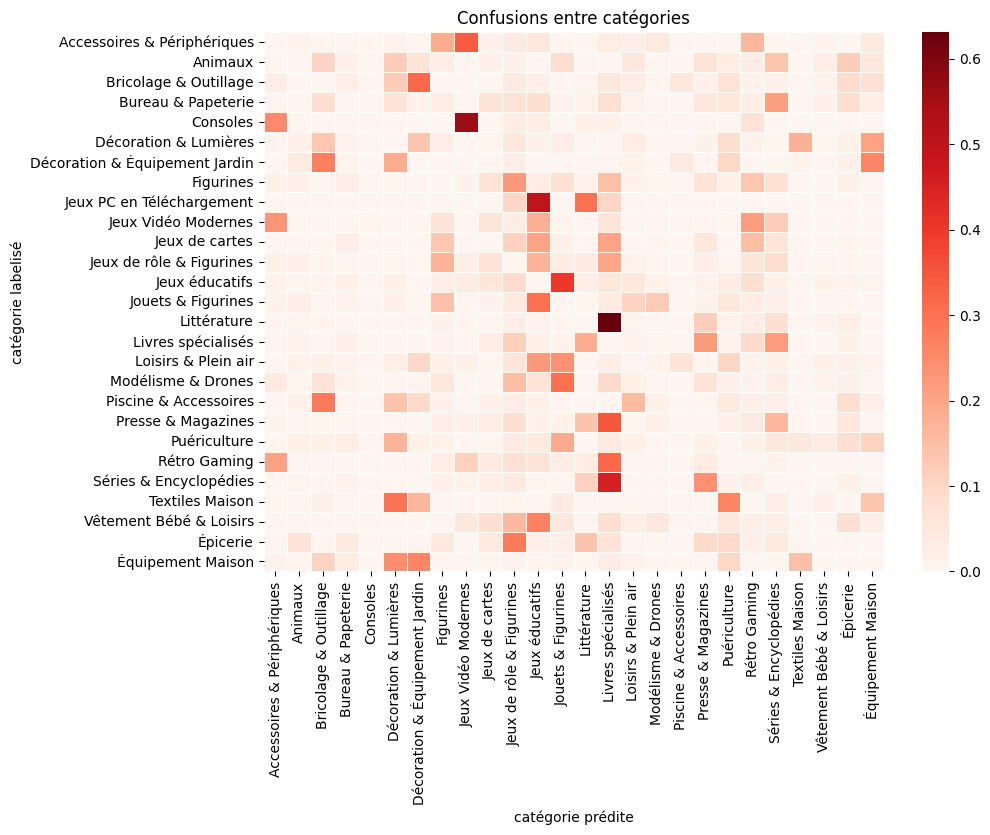

In [39]:
mask = label_issues["is_label_issue"]

ct = pd.crosstab(
    label_issues[mask]["given_label"],
    label_issues[mask]["predicted_label"],
    normalize="index",
)
ct.columns = enc.inverse_transform(ct.columns)
ct.index = enc.inverse_transform(ct.index)

# mask = np.eye(len(ct), dtype=bool)

plt.figure(figsize=(10, 7))
# sns.heatmap(ct, cmap="Reds", mask=mask, linewidths=.5)
sns.heatmap(ct, cmap="Reds", linewidths=0.5)
plt.ylabel("catégorie labelisé")
plt.xlabel("catégorie prédite")
plt.title("Confusions entre catégories")
plt.show()

On peut remarquer que les catégories Jeux éducatif et Jouets, figurine semblent se confondre. Surement du à une proximité. A priori il ya beaucoup d'erreur ou des livres spécialisés sont labelisé comme livre de littérature, un peu moins dans le cas inverse. Les erreurs semblent se produire dans des catégories proches.

# 7 - Analyse sémantique



Nous allons également faire un nuage de mots par catégories celà permettra de contrôler le nomage de catégorie mais également de faire une première analyse sémantique. Pour générer les nuages de mots nous allons d'abord définir une liste stop_words des mots à exclure de nos nuages de mots, puis faire une vectorisation TF-IDF pour génerer les nuages de mots. "Ca permettra de rendre les nuages de mots plus spécifique à chaque catégorie" (à verifier si ça a un sens)

In [65]:
def images_grid(images, nrows=5, ncols=10, cmap=None, titles=None, ordered_by_rows=True, axes_size=(1.5, 1.5)):
    fig, axes = plt.subplots(nrows, ncols, figsize=(axes_size[0]*ncols, axes_size[1]*nrows), squeeze=False)
    axes = axes.flatten()
    if ordered_by_rows:
        axes_order = range(nrows*ncols)
    else:
        axes_order = [i*ncols + j for j in range(ncols) for i in range(nrows)]
    for i in range(nrows*ncols):
        k = axes_order[i]
        if i < len(images):
            axes[k].imshow(images[i], cmap=cmap)
            if titles:
                axes[k].set_title(titles[i], fontsize=8)
        axes[k].set_xticks([])
        axes[k].set_yticks([])
    plt.show()

In [59]:

# on tente sans basculé tout en minuscule

vectorizer = TfidfVectorizer(max_features=2000, stop_words=list(stop_words), ngram_range=(1,2))

text = (df["cleaned_designation"] + " " + df["cleaned_description"].fillna(""))
tfidf = vectorizer.fit_transform(text)
tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)
tfidf["category"] = df["category"].values

tfidf["group"] = df["group"].values

------------------------------ Catégories du groupe Autres ------------------------------


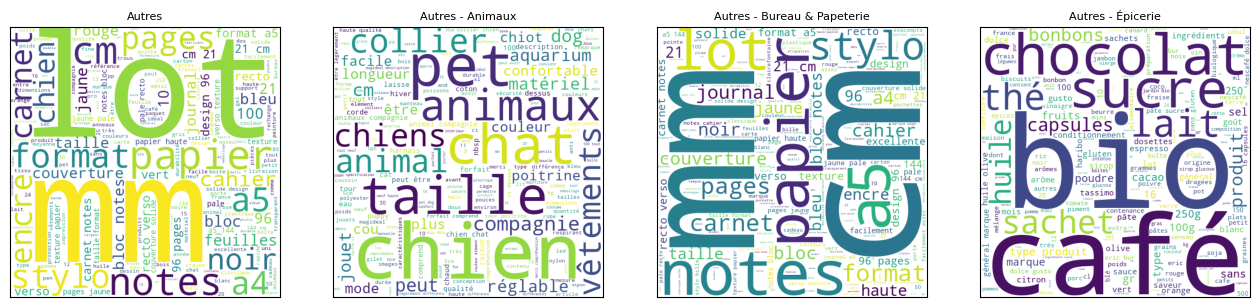

------------------------------ Catégories du groupe Bébé ------------------------------


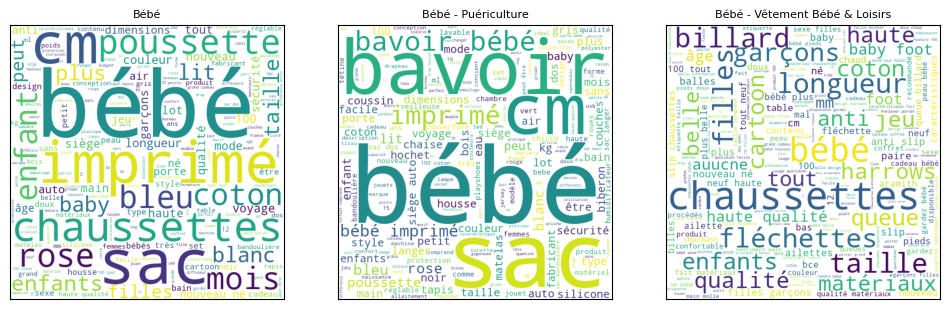

------------------------------ Catégories du groupe Collection ------------------------------


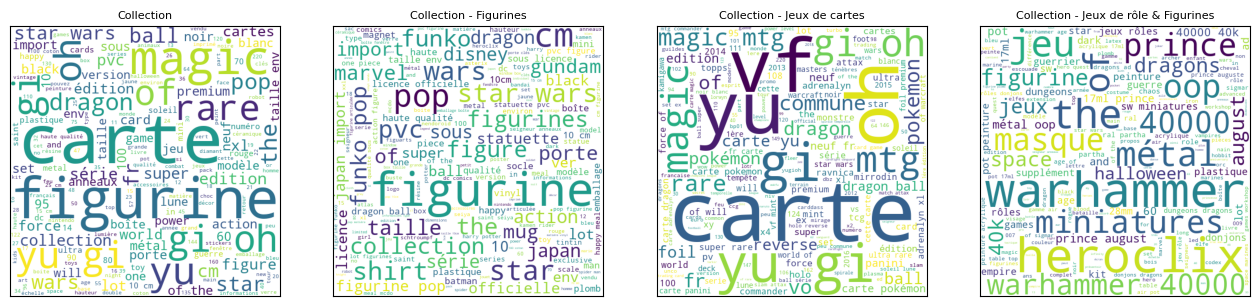

------------------------------ Catégories du groupe Jardin & Extérieur ------------------------------


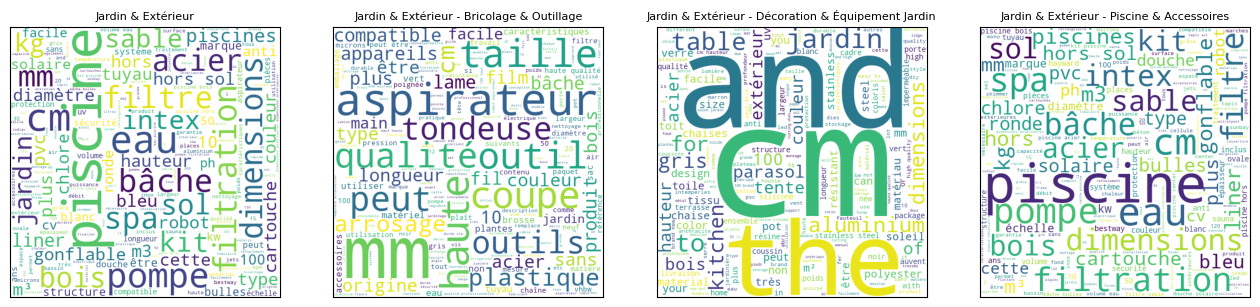

------------------------------ Catégories du groupe Jeux Vidéo ------------------------------


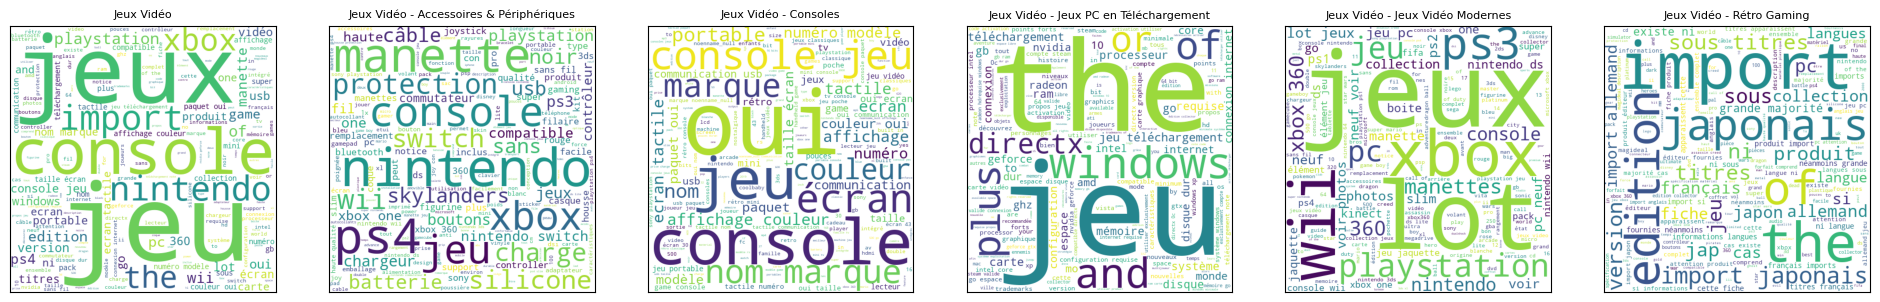

------------------------------ Catégories du groupe Jouets, Jeux & Loisirs ------------------------------


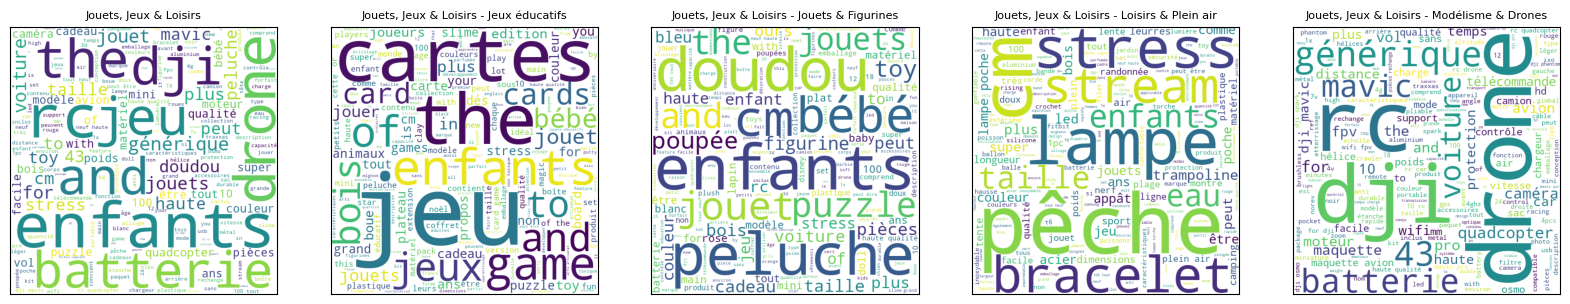

------------------------------ Catégories du groupe Livres & Revues ------------------------------


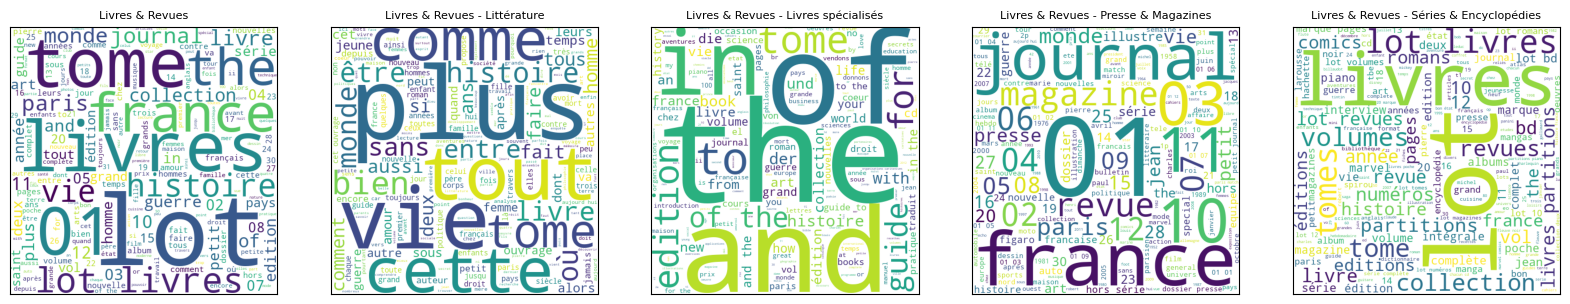

------------------------------ Catégories du groupe Maison ------------------------------


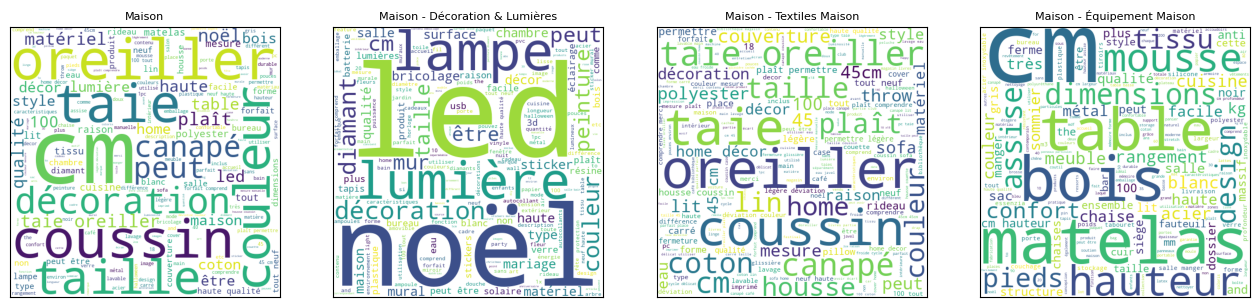

In [70]:
freqs = {}
tfidfgr = {}

for gr in sorted(tfidf["group"].unique()):
    mask = tfidf["group"] == gr
    freqs = {}
    freqs[gr] = tfidf[mask].drop(['category', 'group'], axis=1).mean().sort_values(ascending=False)
    vectorizer = TfidfVectorizer(max_features=2000, stop_words=list(stop_words), ngram_range=(1,2))
    tfidfgr[gr] = vectorizer.fit_transform(text[mask])
    tfidfgr[gr] = pd.DataFrame(tfidfgr[gr].toarray(), columns=vectorizer.get_feature_names_out(), index=df[mask].index)
    tfidfgr[gr]["category"] = df[mask]["category"].values
    means_by_cat = tfidfgr[gr].groupby("category").mean()
    for cat in means_by_cat.index:
        freqs[gr+' - '+cat] = means_by_cat.loc[cat].sort_values(ascending=False)
    wc = [WordCloud(width=500, height=500, background_color="white").generate_from_frequencies(f) for f in freqs.values()]
    print('-'*30,'Catégories du groupe', gr, '-'*30)
    images_grid(wc, 1, len(wc), titles=list(freqs), axes_size=(4,4))

Les nuages de mots semblent être en accord avec les catégories et groupes précédemment choisies. Maintenant que nous avons identifié les catégories et avant d'aller plus loin dans l'analyse sémantique, nous allons regarder la distribution des articles à travers les catégories.

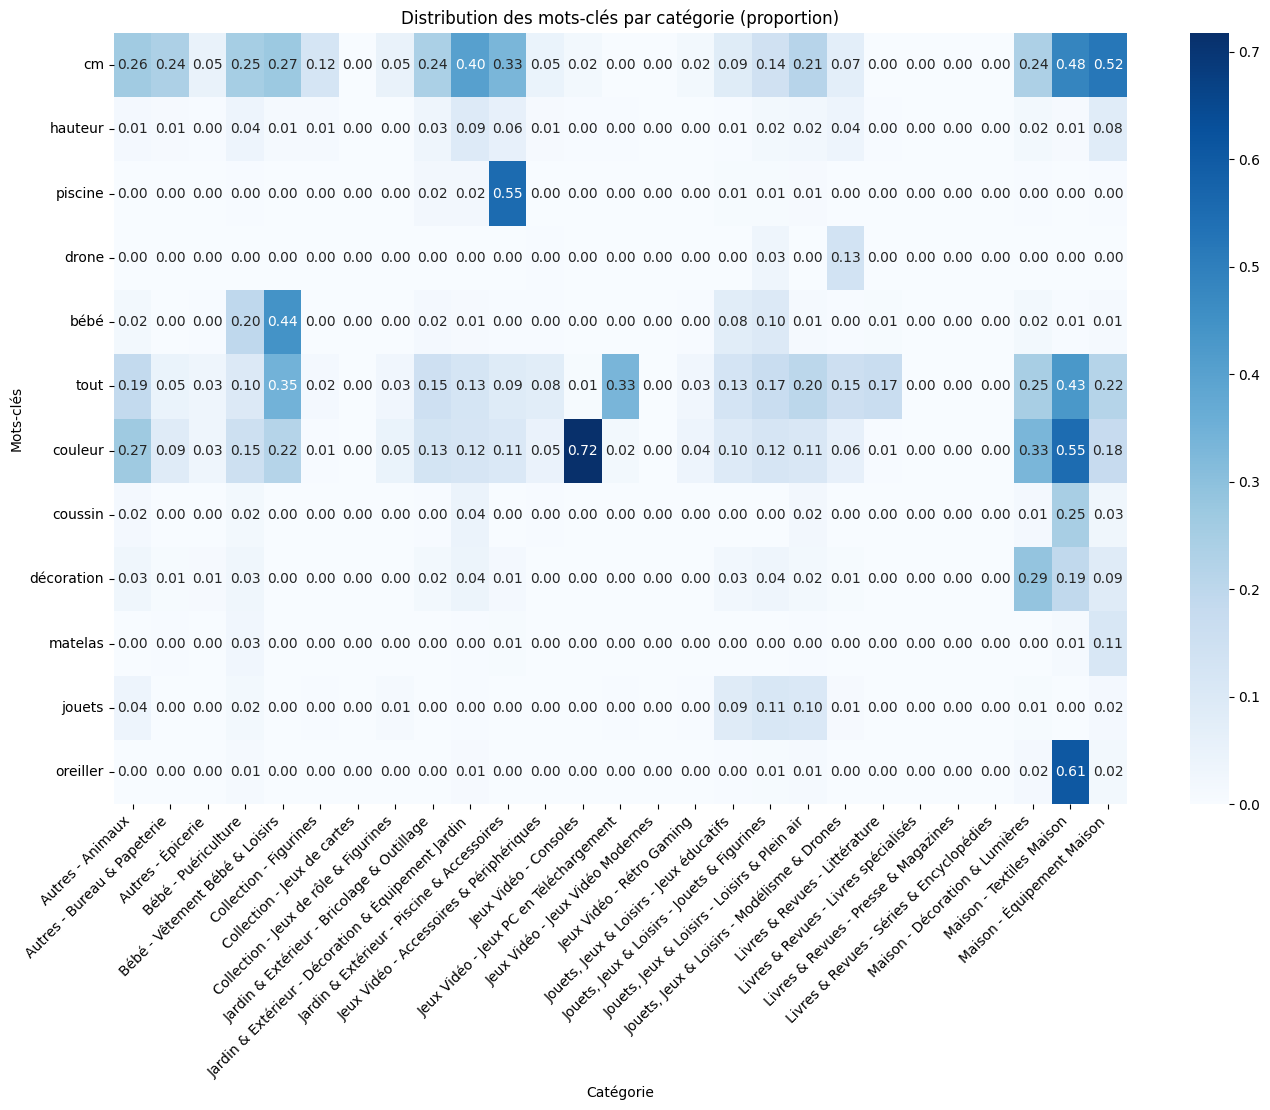

In [82]:
import re

def plot_keywords_heatmap(df, keywords, text_col="text", by="prdtypecode"):
    category_codes = sorted(df[by].unique())
    result = pd.DataFrame(index=keywords, columns=category_codes, dtype=float)
    for kw in keywords:
        pattern = fr"\b{re.escape(kw)}\b"
        contains_kw = df[text_col].astype(str).str.contains(pattern, na=False)
        freq = contains_kw.groupby(df[by]).mean()
        result.loc[kw, freq.index] = freq.values
    col_labels = [categories.get(code, str(code)) for code in category_codes]
    result_for_plot = result.copy()
    result_for_plot.columns = col_labels
    plt.figure(figsize=(14, len(keywords) * 0.6 + 4))
    sns.heatmap(result_for_plot.astype(float), annot=True, fmt=".2f", cmap="Blues")
    plt.title("Distribution des mots-clés par catégorie (proportion)")
    plt.xlabel("Catégorie")
    plt.ylabel("Mots-clés")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


keywords = [ #"temp", "vidéo", "!",
    "cm", "hauteur",
    "piscine", "drone", "bébé", "tout",
    # "led", "&", 
    "couleur",
    "coussin", "décoration", "matelas", "jouets", "oreiller"
]
df['text'] = (df['cleaned_designation'] + ' ' + df['cleaned_description'])
df['group_cat'] = df['group'] + ' - ' + df['category']
plot_keywords_heatmap(df, keywords, by='group_cat')


Les jouets semblent être detécté dans les catégories de jouets mais également dans la catégorie des produits pour animaux. matelas est repéré dans la bonne catégorie dédié (équipement de la maison) mais également dans la catégorie bébé - puériculture pour les matelas bébé, cela semble cohérent.
On peut remarquer qu'il y a des termes qui caractèrisent clairement une catégorie par exemple oreiller et coussin pour Textiles d'intérieur, ou piscine pour Piscine & accessoire car ils sont très rarement présent dans les autres catégories.
Des termes comme cm semble également être plus présente dans certaines catégories.

## A terminer (trouver une anaylse à faire) avec un graphique de ce type

In [80]:
from matplotlib.ticker import PercentFormatter

# Fréquence d'un mot par catégorie + taux de descriptions manquantes
def plot_keyword_per_category(df, keyword, text_col="text"):
    pattern = fr"\b{re.escape(keyword)}\b"
    contains_word = df[text_col].str.contains(pattern, na=False)
    desc_isna = df["description"].isna()
    # Calculer, pour chaque catégorie :
    # - la proportion de produits contenant le mot dans "text"
    # - la proportion de descriptions manquantes
    agg = (
        df.assign(contains_word=contains_word, desc_isna=desc_isna)
          .groupby("prdtypecode")
          .agg(
              contains_ratio=("contains_word", "mean"),
              missing_ratio=("desc_isna", "mean"),
          )
          .reset_index()
    )
    agg["cat_label"] = agg["prdtypecode"].map(categories)
    agg["cat_label"] = agg["cat_label"].fillna(agg["prdtypecode"].astype(str))
    fig, ax1 = plt.subplots(figsize=(12, 5))
    # diagramme en barres montrant la fréquence du mot par catégorie
    sns.barplot(data=agg, x="cat_label", y="contains_ratio", ax=ax1)
    ax1.set_ylabel("Proportion contenant le mot")
    ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
    # ligne montrant le taux de descriptions manquantes
    ax2 = ax1.twinx()
    ax2.plot(
        ax1.get_xticks(),
        agg["missing_ratio"],
        marker="o",
        linestyle="--",
        color='orange'
    )
    ax2.set_ylabel("Proportion de descriptions manquantes")
    ax2.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax1.set_xlabel("Catégorie")
    plt.title(f"Fréquence du mot '{keyword}' par catégorie\n"
              f"(barres = mot, ligne = descriptions manquantes)")
    plt.xticks(rotation=45, ha="right")
    fig.tight_layout()
    plt.show()

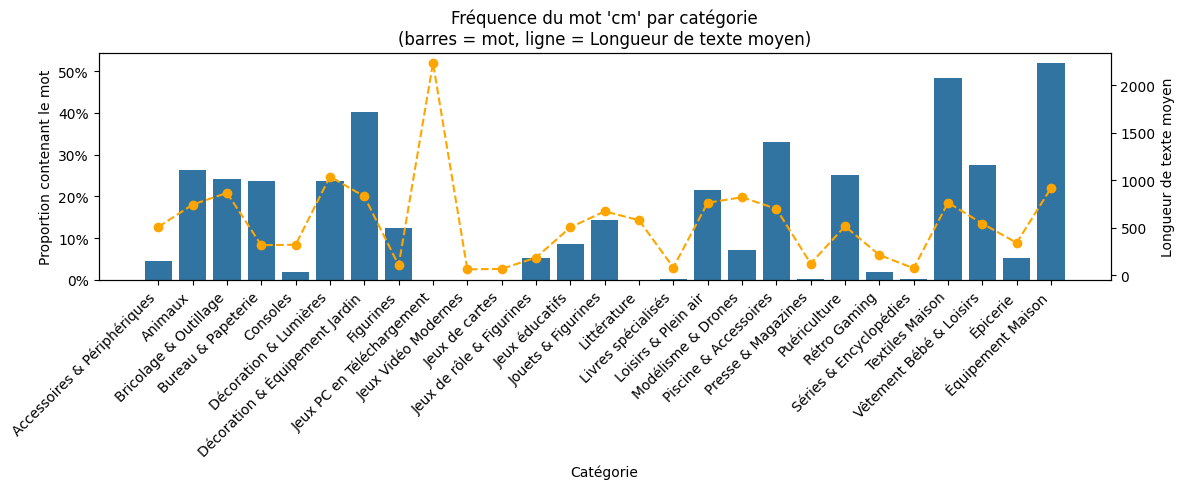

In [100]:
text_col = 'text'
keyword = "cm"
pattern = fr"\b{re.escape(keyword)}\b"
contains_word = df[text_col].str.contains(pattern, na=False)
len_text = df[text_col].apply(len)
agg = df.assign(contains_word=contains_word, len_text=len_text).groupby("category").agg(
    contains_ratio=("contains_word", "mean"),
    mean_len_text=("len_text", "mean"),
).reset_index()
agg
fig, ax1 = plt.subplots(figsize=(12, 5))
plt.xticks(rotation=45, ha="right")
sns.barplot(data=agg, x="category", y="contains_ratio", ax=ax1)
ax1.set_ylabel("Proportion contenant le mot")
ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
ax2 = ax1.twinx()
ax2.plot(ax1.get_xticks(), agg["mean_len_text"], marker="o", linestyle="--", color='orange')
ax2.set_ylabel("Longueur de texte moyen")
ax1.set_xlabel("Catégorie")
plt.title(f"Fréquence du mot '{keyword}' par catégorie\n"
          f"(barres = mot, ligne = Longueur de texte moyen)")

fig.tight_layout()
plt.show()


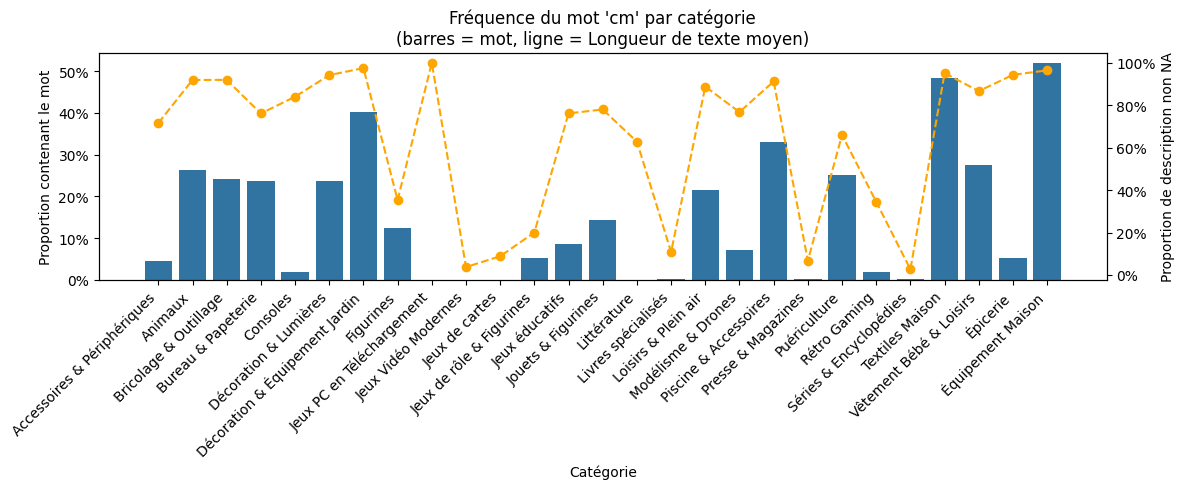

In [104]:
text_col = 'text'
keyword = "cm"
pattern = fr"\b{re.escape(keyword)}\b"
contains_word = df[text_col].str.contains(pattern, na=False)
has_desc = ~df["description"].isna()
agg = df.assign(contains_word=contains_word, has_desc=has_desc).groupby("category").agg(
    contains_ratio=("contains_word", "mean"),
    has_desc_ratio=("has_desc", "mean"),
).reset_index()
agg
fig, ax1 = plt.subplots(figsize=(12, 5))
plt.xticks(rotation=45, ha="right")
sns.barplot(data=agg, x="category", y="contains_ratio", ax=ax1)
ax1.set_ylabel("Proportion contenant le mot")
ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
ax2 = ax1.twinx()
ax2.plot(ax1.get_xticks(), agg["has_desc_ratio"], marker="o", linestyle="--", color='orange')
ax2.yaxis.set_major_formatter(PercentFormatter(1.0))
ax2.set_ylabel("Proportion de description non NA")
ax1.set_xlabel("Catégorie")
plt.title(f"Fréquence du mot '{keyword}' par catégorie\n"
          f"(barres = mot, ligne = Longueur de texte moyen)")

fig.tight_layout()
plt.show()


Pour beaucoup de catégories le taux présence du mots cm semble être lié à la présence de description, mais on peut remarquer que malgré 100% de descriptions présente dans Jeux de PC, le mot 'cm' n'apparait jamais, oupresque. Idem dans littérature qui a plus de 50% de description. Le mot semble être très présent dans ....

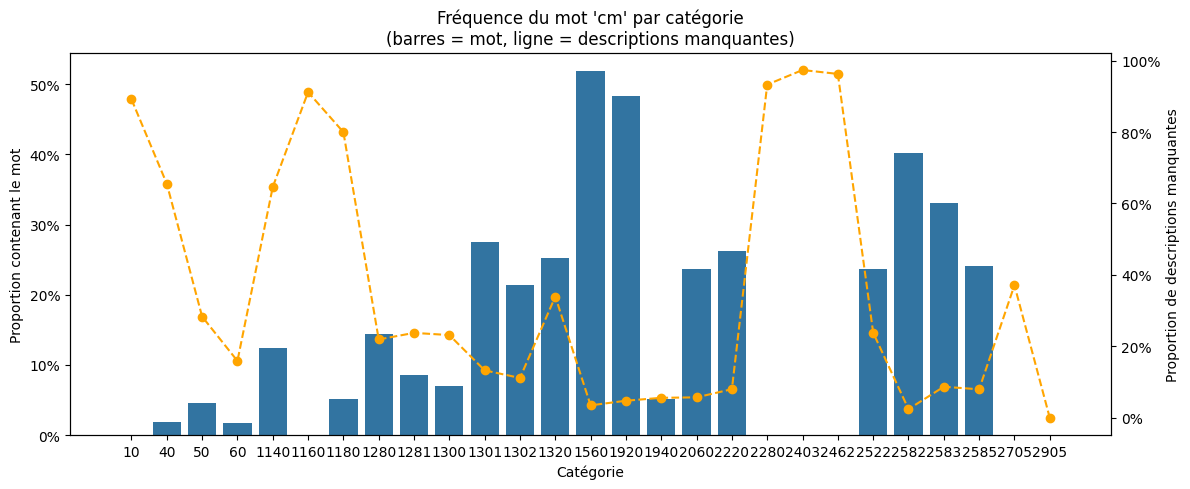

In [84]:
plot_keyword_per_category(df, "cm")

In [ ]:
from matplotlib.ticker import PercentFormatter

# Fréquence d'un mot par catégorie + taux de descriptions manquantes
def plot_keyword_per_category(df, keyword, text_col="text"):
    pattern = fr"\b{re.escape(keyword)}\b"
    contains_word = df[text_col].str.contains(pattern, na=False)
    desc_isna = df["description"].isna()
    # Calculer, pour chaque catégorie :
    # - la proportion de produits contenant le mot dans "text"
    # - la proportion de descriptions manquantes
    agg = (
        df.assign(contains_word=contains_word, desc_isna=desc_isna)
          .groupby("prdtypecode")
          .agg(
              contains_ratio=("contains_word", "mean"),
              missing_ratio=("desc_isna", "mean"),
          )
          .reset_index()
    )
    agg["cat_label"] = agg["prdtypecode"].map(categories)
    agg["cat_label"] = agg["cat_label"].fillna(agg["prdtypecode"].astype(str))
    fig, ax1 = plt.subplots(figsize=(12, 5))
    # diagramme en barres montrant la fréquence du mot par catégorie
    sns.barplot(data=agg, x="cat_label", y="contains_ratio", ax=ax1)
    ax1.set_ylabel("Proportion contenant le mot")
    ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
    # ligne montrant le taux de descriptions manquantes
    ax2 = ax1.twinx()
    ax2.plot(
        ax1.get_xticks(),
        agg["missing_ratio"],
        marker="o",
        linestyle="--",
        color='orange'
    )
    ax2.set_ylabel("Proportion de descriptions manquantes")
    ax2.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax1.set_xlabel("Catégorie")
    plt.title(f"Fréquence du mot '{keyword}' par catégorie\n"
              f"(barres = mot, ligne = descriptions manquantes)")
    plt.xticks(rotation=45, ha="right")
    fig.tight_layout()
    plt.show()

Certaines description sont écrite dans d'autre langue. Nous allons créer une variable comprenant la langue detecté (à l'aide de la librairie detect).

In [102]:
from langdetect import detect, DetectorFactory
from deep_translator import GoogleTranslator

# Fixe la graine pour des résultats reproductibles
DetectorFactory.seed = 0

# Fonction de détection
def detect_lang(text):
    try:
        return detect(text)
    except:
        return "unknown"


# fonction de traduction
def translate_to_fr(text, lang):
    if lang in ['fr', 'unknown']:
        return text
    else:
        return GoogleTranslator(source=lang, target='fr').translate(text)

In [103]:
stop_words = set(stopwords.words('french'))   # on récupère un stopwords adapté au français

# le paramètre ngram_range=(1,2) permet de récupérer unigramme et bigramme
# (par default c'est uniquement les unigrammes, i.e. séquence de un seul mot)
vectorizer = TfidfVectorizer(max_features=2000, stop_words=list(stop_words), ngram_range=(1,2))

text = (df["cleaned_designation"] + " " + df["cleaned_description"].fillna("")).str.lower()
tfidf = vectorizer.fit_transform(text)

tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)
tfidf["category"] = df["category"].values
means_by_prdtypecode = tfidf.groupby("category").mean()
freqs = {
    cat : means_by_prdtypecode.loc[cat].sort_values(ascending=False)
    for cat in tfidf["category"].sort_values().unique()
}

df["detected_lang"] = (df["cleaned_designation"] + ' ' + df["cleaned_description"].fillna("")).apply(detect_lang)

# bcp trop long à tourner
# df["cleaned_designation_fr"] = df.apply(lambda x: translate_to_fr(x["cleaned_designation"], x["detected_lang"]), axis=1)
# df["cleaned_description_fr"] = df.apply(lambda x: translate_to_fr(x["cleaned_description"], x["detected_lang"]), axis=1)

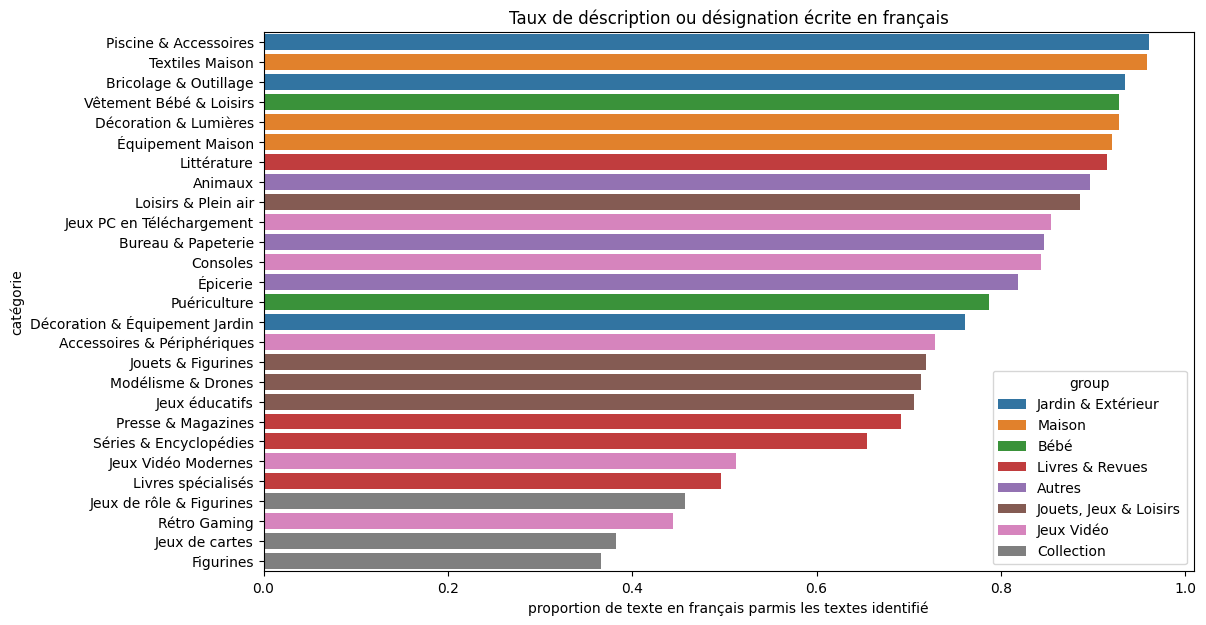

In [111]:
fr_rate = df[df["detected_lang"] == 'fr'][['group', 'category']].value_counts() / df[df["detected_lang"] != 'unknown'][['group', 'category']].value_counts()
fr_rate = fr_rate.sort_values(ascending=False).reset_index()
plt.figure(figsize=(12,7))
sns.barplot(data=fr_rate, x='count', y='category', hue='group')
plt.title("Taux de déscription ou désignation écrite en français")
plt.ylabel('catégorie')
plt.xlabel('proportion de texte en français parmis les textes identifié');

Il faut faire attention à ce graphique car il semble avoir plus d'erreur de detection pour des textes court ou le nom de objet est dans une langue étrangère par exemple carte star wars

# 8 - Taguer potentiels doublons

Conclusion :

## Difficultés et biais du jeu de données

-   forte variabilité et bruit dans les textes
-   classes  déséquilibrées
-   description absente pour plus d'un tiers des produits
-   doublons fréquents
-   hétérogénéité linguistique des descriptions et commentaires



Nous allons maintenant faire l'analyse des images dans un second notebook.